In [1]:
# Some setting up stuff. This cell is hidden from the Sphinx-rendered documentation.
%load_ext tikzmagic
%matplotlib inline
%config InlineBackend.figure_format = 'png'
np.random.seed(42)

# Multinomial distribution: bags of marbles

*Written by: Deebul Nair (2016)*

*Edited by: Jaakko Luttinen (2016)*

*Inspired by https://probmods.org/hierarchical-models.html*


## Using multinomial distribution

There are several bags of coloured marbles, each bag containing different amounts of each color. Marbles are drawn at random with replacement from the bags. The goal is to predict the distribution of the marbles in each bag.

### Data generation

Let us create a dataset. First, decide the number of bags, colors and trials (i.e., draws):

In [2]:
n_colors = 5  # number of possible colors
n_bags = 3    # number of bags
n_trials = 20 # number of draws from each bag

Generate randomly a color distribution for each bag:

In [3]:
from bayespy import nodes
import numpy as np

p_colors = nodes.Dirichlet(n_colors * [0.5], plates=(n_bags,)).random()

The concentration parameter $\begin{bmatrix}0.5 & \ldots & 0.5\end{bmatrix}$ makes the distributions very non-uniform within each bag, that is, the amount of each color can be very different. We can visualize the probability distribution of the colors in each bag:

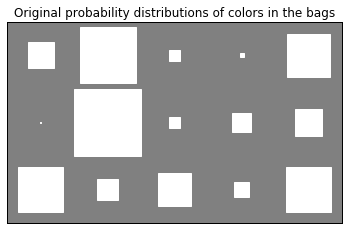

In [4]:
import bayespy.plot as bpplt
bpplt.hinton(p_colors)
bpplt.pyplot.title("Original probability distributions of colors in the bags");

As one can see, the color distributions aren't very uniform in any of the bags because of the small concentration parameter. Next, make the ball draws:

In [5]:
marbles = nodes.Multinomial(n_trials, p_colors).random()
print(marbles)

[[ 0  9  2  0  9]
 [ 0 18  0  0  2]
 [ 5  2  1  3  9]]


### Model

We will use the same generative model for estimating the color distributions in the bags as we did for generating the data:
$$
\theta_i \sim \mathrm{Dirichlet}\left(\begin{bmatrix} 0.5 & \ldots & 0.5 \end{bmatrix}\right)
$$

$$
y_i | \theta_i \sim \mathrm{Multinomial}(\theta_i)
$$

The simple graphical model can be drawn as below:

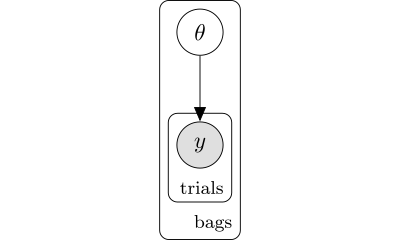

In [6]:
%%tikz -f svg
\usetikzlibrary{bayesnet}
\node [latent] (theta) {$\theta$};
\node [below=of theta, obs] (y) {$y$};
\edge {theta} {y};
\plate {trials} {(y)} {trials};
\plate {bags} {(theta)(y)(trials)} {bags};

The model is constructed equivalently to the generative model (except we don't use the nodes to draw random samples):

In [7]:
theta = nodes.Dirichlet(n_colors * [0.5], plates=(n_bags,))
y = nodes.Multinomial(n_trials, theta)

Data is provided by using the `observe` method:

In [8]:
y.observe(marbles)

### Performing Inference

In [9]:
from bayespy.inference import VB
Q = VB(y, theta)
Q.update(repeat=1000)

Iteration 1: loglike=-2.617894e+01 (0.001 seconds)
Iteration 2: loglike=-2.617894e+01 (0.001 seconds)
Converged at iteration 2.


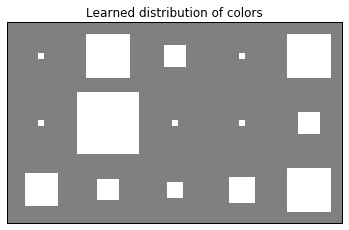

In [10]:
import bayespy.plot as bpplt
bpplt.hinton(theta)
bpplt.pyplot.title("Learned distribution of colors")
bpplt.pyplot.show()

## Using categorical Distribution

The same problem can be solved with categorical distirbution. Categorical distribution is similar to the Multinomical distribution expect for the output it produces.

Multinomial and Categorical infer the number of colors from the size of the probability vector (p_theta)
Categorical data is in a form where the value tells the index of the color that was picked in a trial. so if n_colors=5, Categorical data could be [4, 4, 0, 1, 1, 2, 4] if the number of trials was 7. 

multinomial data is such that you have a vector where each element tells how many times that color was picked, for instance, [3, 0, 4] if you have 7 trials.

So there is significant difference in Multinomial and Categorical data . Depending on the data you have the choice of the Distribution has to be made.

Now we can see an example of Hierarchical model usign categorical data generator and model

In [11]:
from bayespy import nodes
import numpy as np

#The marbles drawn based on the distribution for 10 trials
# Using same p_color distribution as in the above example
draw_marbles = nodes.Categorical(p_colors,
                                 plates=(n_trials, n_bags)).random()

### Model

In [12]:
from bayespy import nodes
import numpy as np

p_theta = nodes.Dirichlet(np.ones(n_colors),
                          plates=(n_bags,),
                          name='p_theta')

bag_model = nodes.Categorical(p_theta,
                        plates=(n_trials, n_bags),
                        name='bag_model')

### Inference

In [13]:
bag_model.observe(draw_marbles)

In [14]:
from bayespy.inference import VB
Q = VB(bag_model, p_theta)

In [15]:
Q.update(repeat=1000)

Iteration 1: loglike=-6.595923e+01 (0.001 seconds)
Iteration 2: loglike=-6.595923e+01 (0.001 seconds)
Converged at iteration 2.


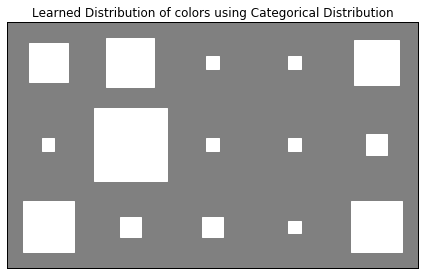

In [16]:
%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p_theta)
bpplt.pyplot.tight_layout()
bpplt.pyplot.title("Learned Distribution of colors using Categorical Distribution")
bpplt.pyplot.show()